In [12]:
import gym
from gym import Env, spaces

import numpy as np
import seaborn as sns
from plotly.offline import iplot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import random
import networkx as nx
import matplotlib.patches as mpatches




Configurar o Enxame


In [13]:
num_drones = 6
limite_y = 80
limite_x = 100

alcance_comunicacao_jammer = 25
alcance_comunicacao_nos=5000
B_Hz = 2.4e9  # Largura de banda

# Posições estáticas dos drones
posicoes = np.array([[16, 30], [18, 48], [44, 15], [23, 73], [45, 73], [50, 50]])

posicao_jammer = np.array([33, 58])

VIZUALIZAÇÃO DAS DIREÇÕES DAS ANTENAS ESCOLHIDAS ALEATORIAMENTE

In [14]:
# Função para calcular a distância entre duas posições
def distancia(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

# Função para encontrar vizinhos dentro do alcance de comunicação
def encontra_vizinhos(posicoes, alcance_comunicacao_nos):
    num_drones = posicoes.shape[0]
    vizinhos = {}
    for i in range(num_drones):
        vizinhos[i] = []
        for j in range(num_drones):
            if i != j and distancia(posicoes[i], posicoes[j]) <= alcance_comunicacao_nos:
                vizinhos[i].append(j)
    return vizinhos

# Função para verificar quais drones são afetados pelo jammer
def verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer):
    afetados_pelo_jammer = []
    for i in range(posicoes.shape[0]):
        if distancia(posicoes[i], posicao_jammer) <= alcance_comunicacao_jammer:
            afetados_pelo_jammer.append(i)
    return afetados_pelo_jammer

# Gera direções aleatórias para as antenas
direcoes_antena = np.random.uniform(0, 360, size=num_drones)
# direcoes_antena = [278, 102, 235, 312, 182, 242]
afetados_pelo_jammer=verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer)
# Comprimento das setas para indicar a direção das antenas
comprimento_seta = 5

# Criar a figura
fig = go.Figure()

# Adiciona os drones
for i in range(num_drones):
    cor = 'blue' if i in afetados_pelo_jammer else 'blue' # type: ignore
    fig.add_trace(go.Scatter(
        x=[posicoes[i, 0]],
        y=[posicoes[i, 1]],
        mode='markers+text',
        marker=dict(size=10, color=cor),
        text=str(i),
        textposition="bottom center",
        showlegend=False
    ))

    # Calcular as coordenadas da seta para a direção da antena
    direcao_radianos = np.radians(direcoes_antena[i])
    dx = comprimento_seta * np.cos(direcao_radianos)
    dy = comprimento_seta * np.sin(direcao_radianos)
    seta_x = posicoes[i, 0] + dx
    seta_y = posicoes[i, 1] + dy
    
    # Adiciona uma linha para indicar a direção da antena
    fig.add_trace(go.Scatter(
        x=[posicoes[i, 0], seta_x],
        y=[posicoes[i, 1], seta_y],
        mode='lines',
        line=dict(color='black', width=1.5),
        showlegend=False
    ))

# Adiciona o jammer
fig.add_trace(go.Scatter(
    x=[posicao_jammer[0]],
    y=[posicao_jammer[1]],
    mode='markers',
    marker=dict(size=12, color='red'),
    name='Jammer'
))

# Adiciona rastros para a legenda
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='blue'), name="Drone"))
# fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='orange'), name="Nó afetado"))

# Configurações do gráfico
fig.update_layout(
    title="Simulação de Modelo de Comunicação Wireless entre Drones",
    xaxis=dict(range=[0, limite_x], autorange=False),
    yaxis=dict(range=[0, limite_y], autorange=False),
    legend_title_text='Legenda',
    legend=dict(traceorder='normal', itemsizing='constant')
)

fig.show()
print(direcoes_antena)

c:\Users\tass\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



[175.71578625  98.52809923 322.15353857 139.98547395 143.93143217
 245.7939933 ]


CALCULO DE TODOS OS ANGULOS A USAR

In [15]:
import numpy as np

# Função para calcular o ângulo entre dois nós em relação à direção da antena
def angulo_entre_nos(pos1, direcao_antena, pos2):
    # Vetor entre os dois nós
    delta_x = pos2[0] - pos1[0]
    delta_y = pos2[1] - pos1[1]
    
    # Direção do vetor em graus
    direcao_vetor_rad = np.arctan2(delta_y, delta_x)
    direcao_vetor_deg = np.degrees(direcao_vetor_rad)
    
    # Diferença entre a direção do vetor e a direção da antena
    angulo = direcao_vetor_deg - direcao_antena
    
    # Ajustar para o intervalo de 0 a 360 graus
    angulo = angulo % 360  # Usa módulo para garantir que o valor esteja entre 0 e 360
    angulo_arredondado = round(angulo)
    
    return angulo_arredondado

# Posições dos drones
# posicoes = np.array([[16, 30], [18, 48], [44, 15], [23, 73], [45, 73], [50, 50]])

# Direções aleatórias das antenas
# direcoes_antena = np.random.uniform(0, 360, size=posicoes.shape[0])

# Matriz para armazenar os ângulos
angulos_matriz = np.zeros((posicoes.shape[0], posicoes.shape[0]))

# Calcular os ângulos para todas as combinações de drones
for i in range(posicoes.shape[0]):
    for j in range(posicoes.shape[0]):
        if i != j:
            angulos_matriz[i, j] = angulo_entre_nos(posicoes[i], direcoes_antena[i], posicoes[j])

# Apresentar os ângulos entre drones sem valores negativos
for i in range(posicoes.shape[0]):
    print(f"Drones que o drone {i} 'vê' e seus ângulos:")
    for j in range(posicoes.shape[0]):
        if i != j:
            angulo_arredondado = int(round(angulos_matriz[i, j]))  # Arredondar para unidade
            print(f"  Com o drone {j}: {angulo_arredondado} graus")

Drones que o drone 0 'vê' e seus ângulos:
  Com o drone 1: 268 graus
  Com o drone 2: 156 graus
  Com o drone 3: 265 graus
  Com o drone 4: 240 graus
  Com o drone 5: 215 graus
Drones que o drone 1 'vê' e seus ângulos:
  Com o drone 0: 165 graus
  Com o drone 2: 210 graus
  Com o drone 3: 340 graus
  Com o drone 4: 304 graus
  Com o drone 5: 265 graus
Drones que o drone 2 'vê' e seus ângulos:
  Com o drone 0: 190 graus
  Com o drone 1: 166 graus
  Com o drone 3: 148 graus
  Com o drone 4: 127 graus
  Com o drone 5: 118 graus
Drones que o drone 3 'vê' e seus ângulos:
  Com o drone 0: 121 graus
  Com o drone 1: 119 graus
  Com o drone 2: 150 graus
  Com o drone 4: 220 graus
  Com o drone 5: 180 graus
Drones que o drone 4 'vê' e seus ângulos:
  Com o drone 0: 92 graus
  Com o drone 1: 79 graus
  Com o drone 2: 125 graus
  Com o drone 3: 36 graus
  Com o drone 5: 138 graus
Drones que o drone 5 'vê' e seus ângulos:
  Com o drone 0: 325 graus
  Com o drone 1: 298 graus
  Com o drone 2: 14 gr

PARAMETROS 


In [16]:
Ptx_dBm = 30 
f = 2.4e9 
B_Hz= 2.4e9
d0=1
gamma=2
sigma = 8
c=3e8
lambda_m=c/f
L0=-40
potencia_jammer_dBm =100

# Ler o arquivo de ganhos para criar uma tabela de busca
ganhos_df = pd.read_csv('ganhos.csv')

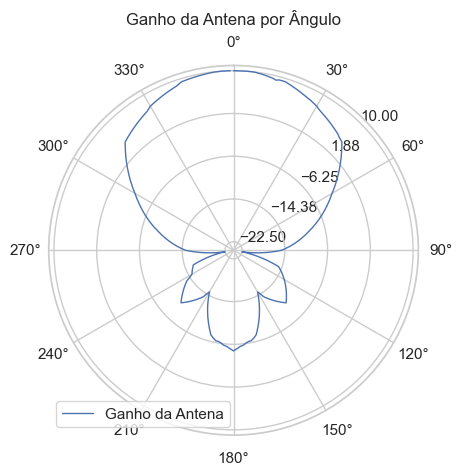

In [17]:
angulos = np.deg2rad(ganhos_df['angulo'])  # Converter graus para radianos
ganhos = ganhos_df['ganho']

# Criar um gráfico polar
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angulos, ganhos, linestyle='-', linewidth=1, label='Ganho da Antena')

# Ajustar o layout
ax.set_theta_zero_location('N')  # Configurar a direção Norte como o topo do gráfico
ax.set_theta_direction(-1)  # Configurar a direção dos ângulos para sentido horário
ax.set_rmax(max(ganhos) + 1)  # Ajustar o raio máximo para melhor visualização
ax.set_rticks(np.linspace(min(ganhos), max(ganhos), num=5))  # Definir os ticks para o raio
ax.set_rlabel_position(45)  # Posicionar os labels do raio

# Configurar os ticks para o ângulo
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))  # Definir marcas de ângulo a cada 30 graus

# Adicionar legenda e título
ax.legend()
ax.set_title('Ganho da Antena por Ângulo', va='bottom')

# Mostrar o gráfico
plt.show()

In [18]:
def busca_ganhos( angulo):
    # Arredondar para o ângulo inteiro mais próximo
    angulo_ajustado = int(round(angulo))
    
    if angulo_ajustado==360:
        angulo_ajustado=0
    
    # Encontrar o ganho correspondente ao ângulo ajustado
    ganho = ganhos_df.loc[ganhos_df['angulo'] == angulo_ajustado, 'ganho'].iloc[0]
    
    return ganho



# Função para calcular os ganhos de transmissão e recepção
def calcula_ganhos(posicoes, direcoes_antena, indice_transmissor, indice_receptor, ganhos_df):
    # Obter posições e direções
    pos1 = posicoes[indice_transmissor]
    pos2 = posicoes[indice_receptor]
    direcao_antena1 = direcoes_antena[indice_transmissor]
    direcao_antena2 = direcoes_antena[indice_receptor]
    
    # Calcular o ângulo entre os dois nós em relação à direção da antena
    angulo_transmissao = angulo_entre_nos(pos1, direcao_antena1, pos2)
    angulo_rececao = angulo_entre_nos(pos2, direcao_antena2, pos1)
    # print('Angulo receção:',angulo_rececao)
    # print('Angulo tranmissão:',angulo_transmissao)

    # Obter os ganhos para transmissão e recepção
    ganho_transmissao = busca_ganhos( angulo_transmissao)
    ganho_rececao = busca_ganhos( angulo_rececao)
    
    return ganho_transmissao, ganho_rececao

ganho_transmissao, ganho_rececao = calcula_ganhos(posicoes, direcoes_antena, 0, 1, ganhos_df)



def calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d,f):
    """
    Calcula a potência do sinal recebido usando a equação de Path Log Distance.
    """
    L = (4 * np.pi * d / lambda_m)**2
    Prx_dBm = Ptx_dBm + ganho_transmissao + ganho_rececao - 10 * np.log10(L)
    return Prx_dBm

def calcula_potencia_jammer(pos_drone, direcao_antena_drone, pos_jammer, potencia_jammer_dBm, ganhos_df):
    # Calcular a distância entre o drone e o jammer
    d = distancia(pos_drone, pos_jammer)
    
    # Calcular o ângulo entre o drone e o jammer
    angulo_entre_drone_e_jammer = angulo_entre_nos(pos_drone, direcao_antena_drone, pos_jammer)
    
    # Obter o ganho do drone em direção ao jammer
    ganho_drone_para_jammer = busca_ganhos( angulo_entre_drone_e_jammer)
    
    # Calcular a potência do ruído recebido usando a equação de Friis
    L = (4 * np.pi * d / lambda_m) ** 2  # Perda de propagação
    potencia_jammer_recebida_dBm = potencia_jammer_dBm + ganho_drone_para_jammer - 10 * np.log10(L)
    
    return potencia_jammer_recebida_dBm

def calcula_capacidade(potencia_sinal_dBm, potencia_ruido_dBm):
    """
    Calcula a capacidade do canal em bits por segundo usando a fórmula de Shannon-Hartley.
    """
    # Converter potência em dBm para Watts
    potencia_sinal_W = 10 ** (potencia_sinal_dBm / 10) / 1000  # Potência do sinal em Watts
    potencia_ruido_W = 10 ** (potencia_ruido_dBm / 10) / 1000  # Potência do ruído em Watts
    
    # Calcular a razão sinal-ruído (SNR)
    snr = potencia_sinal_W / potencia_ruido_W
    
    # Calcular a capacidade do canal em bits por segundo (bps)
    capacidade = B_Hz * np.log2(1 + snr)
    
    return capacidade/1e3

# -------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------
for i in range(posicoes.shape[0]):
    for j in range(posicoes.shape[0]):
        if i != j:
            # Calcular a distância entre os dois drones
            d = distancia(posicoes[i], posicoes[j])
            
            # Calcular os ganhos de transmissão e recepção
            ganho_transmissao, ganho_rececao = calcula_ganhos(posicoes, direcoes_antena, i, j, ganhos_df)
            # print(posicoes)
            print('Ganhos Rx,Tx:',ganho_transmissao, ganho_rececao)
            # Calcular a potência do sinal recebido usando a equação de Friis
            potencia_recebida = calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d, lambda_m)
            potencia_ruido = calcula_potencia_jammer(posicoes[j], direcoes_antena[j], posicao_jammer, potencia_jammer_dBm, ganhos_df)
            capacidade_canal=calcula_capacidade(potencia_recebida,potencia_ruido)
            # Imprimir a combinação de nós e a potência do sinal recebido
            print(f"  Potencia recebida do drone {i} para o drone {j}: {potencia_recebida:.2f} dBm")
            print(f"  Ruido recebido no drone {j} e do jammer: {potencia_ruido:.2f} dBm")
            print(f"  Capacidade do canal {i} para {j}: {capacidade_canal:.2f} bps")



Ganhos Rx,Tx: -16.5 -7.5
  Potencia recebida do drone 0 para o drone 1: -59.20 dBm
  Ruido recebido no drone 1 e do jammer: 30.19 dBm
  Capacidade do canal 0 para 1: 0.00 bps
Ganhos Rx,Tx: -12.0 -6.6
  Potencia recebida do drone 0 para o drone 2: -58.68 dBm
  Ruido recebido no drone 2 e do jammer: 14.91 dBm
  Capacidade do canal 0 para 2: 0.15 bps
Ganhos Rx,Tx: -18.75 -12.8
  Potencia recebida do drone 0 para o drone 3: -74.38 dBm
  Ruido recebido no drone 3 e do jammer: 26.84 dBm
  Capacidade do canal 0 para 3: 0.00 bps
Ganhos Rx,Tx: -15.0 -16.5
  Potencia recebida do drone 0 para o drone 4: -75.84 dBm
  Ruido recebido no drone 4 e do jammer: 20.48 dBm
  Capacidade do canal 0 para 4: 0.00 bps
Ganhos Rx,Tx: -13.0 6.5
  Potencia recebida do drone 0 para o drone 5: -48.47 dBm
  Ruido recebido no drone 5 e do jammer: 18.73 dBm
  Capacidade do canal 0 para 5: 0.66 bps
Ganhos Rx,Tx: -7.5 -16.5
  Potencia recebida do drone 1 para o drone 0: -59.20 dBm
  Ruido recebido no drone 0 e do jammer:

CRIAR O ENVIRONMENT

In [19]:
class UAVCommunicationEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, num_uavs=num_drones, area_size=(100, 100)):
        super().__init__()
        self.num_uavs = num_uavs
        self.area_size = area_size
        self.posicoes = posicoes
        self.posicao_jammer = posicao_jammer
        self.ultimo_info = {}

        # Define o espaço de ação como direções para cada drone
        self.action_space = spaces.MultiDiscrete([360] * num_uavs)
        self.observation_space = spaces.MultiDiscrete([360] * num_uavs)
        self.direcoes_antena = np.random.uniform(0, 360, size=num_uavs)
        
        
    def step(self, action):
        self.direcoes_antena = np.array(action)
        total_capacidades = 0
        capacidade_media=0
        capacidades_por_link = []
        
        # assert len(action) == self.num_uavs

        # Iterar por todos os drones para calcular a capacidade entre eles
        for i in range(self.posicoes.shape[0]):
            for j in range(self.posicoes.shape[0]):
                if i != j:
                    # Calcular a distância entre os dois drones
                    d = distancia(posicoes[i], posicoes[j])
                    # Calcular os ganhos de transmissão e recepção
                    ganho_transmissao, ganho_rececao = calcula_ganhos(posicoes, self.direcoes_antena, i, j, ganhos_df)
                    # Calcular a potência do sinal recebido usando a equação de Friis
                    potencia_recebida = calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d, lambda_m)
                    potencia_ruido = calcula_potencia_jammer(posicoes[j], self.direcoes_antena[j], posicao_jammer, potencia_jammer_dBm, ganhos_df)
                    capacidade_canal=calcula_capacidade(potencia_recebida,potencia_ruido)
                    capacidades_por_link.append(capacidade_canal)
                    total_capacidades += capacidade_canal

        # Recompensa é a soma das capacidades de todos os links
        capacidade_media=np.mean(capacidades_por_link)
        recompensa = capacidade_media
        capacidades_por_link = [round(capacidade, 3) for capacidade in capacidades_por_link]
        capacidade_media = round(capacidade_media, 3)
        
        capacidade_matriz = np.zeros((num_drones, num_drones))
        link_index = 0
        

        for i in range(num_drones):
            for j in range(num_drones):
                if i != j:
                    capacidade_matriz[i, j] = capacidades_por_link[link_index]
                    link_index += 1

        
        # Informação adicional a ser retornada
        info = {
            'Capacidade média [Kbps]': capacidade_media,
            'Capacidades_por_link [Kbps]': capacidades_por_link,
            'Matriz de Capacidades [Kbps]': capacidade_matriz
            
        }

        # Retorna a observação, recompensa, indicador de fim de episódio e informações adicionais
        return np.array(self.direcoes_antena), recompensa, done, info
    
    def render(self, mode='human'):
        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(9, 4))

        # Desenha os drones no gráfico
        for i, pos in enumerate(self.posicoes):
            ax.scatter(pos[0], pos[1], color='blue', s=100, label='Drone' if i == 0 else "")
            ax.text(pos[0], pos[1] - 2, f'{i}', horizontalalignment='center', color='white', fontweight='bold')

        # Desenha as setas para a direção das antenas
        comprimento_seta = 5  # Comprimento das setas
        for i, direcao in enumerate(self.direcoes_antena):
            direcao_rad = np.radians(direcao)  # Converte para radianos
            dx = comprimento_seta * np.cos(direcao_rad)  # Deslocamento em x
            dy = comprimento_seta * np.sin(direcao_rad)  # Deslocamento em y
            
            ax.arrow(
                self.posicoes[i][0], self.posicoes[i][1], 
                dx, dy, 
                head_width=2, head_length=2, fc='b', ec='b'
            )  # Seta azul para indicar a direção da antena

        # Desenha o jammer
        ax.scatter(self.posicao_jammer[0], self.posicao_jammer[1], color='red', s=100, marker='o', label='Jammer')

        # Configurações finais do gráfico
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(0, self.area_size[0])
        ax.set_ylim(0, self.area_size[1])
        plt.title('Direções das Antenas UAV')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

        plt.show()
        
    def reset(self):
        self.direcoes_antena = np.random.uniform(0, 360, size=self.num_uavs)
        assert len(self.direcoes_antena) == self.num_uavs, "Número incorreto de direções"
        obs = np.array(self.direcoes_antena)
        return obs, {}

TESTAR

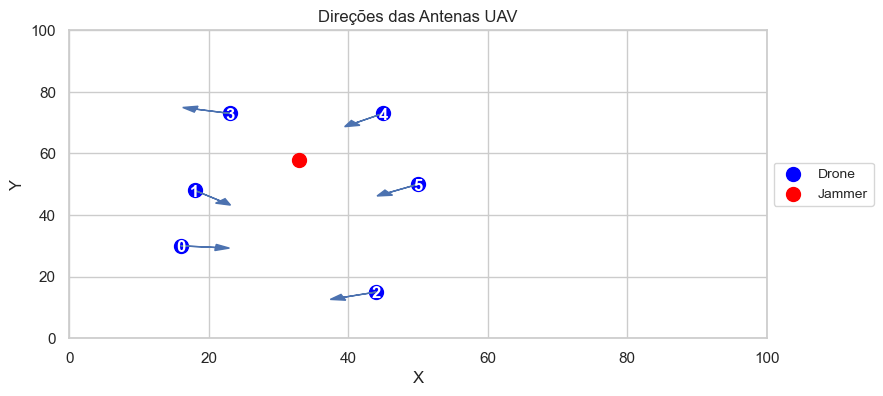

Direções Estabelecidas:

[354 317 200 164 218 213]

Capacidade Média [Kbps]:
36.686

Capacidade por Link [Kbps]:
[0.13, 963.608, 0.0, 0.021, 4.899, 0.132, 56.507, 0.002, 0.005, 2.444, 17.183, 0.999, 0.001, 0.0, 0.011, 0.0, 0.001, 0.033, 0.019, 0.001, 1.564, 0.363, 0.736, 2.096, 0.003, 30.759, 15.215, 3.829, 0.012, 0.0]

Matriz de Capacidades [Kbps]:
	0.00 0.13 963.61 0.00 0.02 4.90
	0.13 0.00 56.51 0.00 0.01 2.44
	17.18 1.00 0.00 0.00 0.00 0.01
	0.00 0.00 0.03 0.00 0.02 0.00
	1.56 0.36 0.74 2.10 0.00 0.00
	30.76 15.21 3.83 0.01 0.00 0.00


In [20]:
env = UAVCommunicationEnv()

state = env.reset()
done = False
while not done:
    action = env.action_space.sample()  # Exemplo: escolha uma ação aleatoriamente
    state, reward, done, info = env.step(action)
    env.render()  # Chame render a cada passo para visualizar
    
    # print(info)
    
    print('Direções Estabelecidas:\n')
    print(state)
    
    if 'Capacidade média [Kbps]' in info:
        print("\nCapacidade Média [Kbps]:")
        capacidade_media=info['Capacidade média [Kbps]']
        print(capacidade_media)
    
    if 'Capacidades_por_link [Kbps]' in info:
        print("\nCapacidade por Link [Kbps]:")
        capacidade_por_link=info['Capacidades_por_link [Kbps]']
        print(capacidade_por_link)
    
    
    if 'Matriz de Capacidades [Kbps]' in info:
        print("\nMatriz de Capacidades [Kbps]:")
        capacidade_matriz = info['Matriz de Capacidades [Kbps]']
        print('\n'.join(['\t' + ' '.join(f"{item:.2f}" for item in row) for row in capacidade_matriz]))
    else:
        print("Chave 'Matriz de Capacidades[Kbps]' não encontrada em info.")
    done=True

ALGORITMO GENETICO

1.Tamanho da População:

    Maior: Uma população maior oferece uma diversidade genética mais ampla, o que pode ajudar a evitar mínimos locais, mas também aumenta o custo computacional.
    Menor: Uma população menor pode levar a uma convergência mais rápida, mas pode ficar presa em mínimos locais.

2.Taxa de Mutação:

    Alta: Uma taxa de mutação mais alta aumenta a diversidade genética dentro da população e pode ajudar a sair de mínimos locais. No entanto, se for muito alta, pode causar uma busca aleatória, reduzindo a eficiência do algoritmo.
    Baixa: Uma taxa de mutação baixa mantém a estabilidade da população, mas pode resultar em convergência prematura para soluções subótimas.

3.Taxa de Cruzamento:

    Alta: Promove a combinação de características de diferentes indivíduos, potencialmente levando a uma melhoria mais rápida.
    Baixa: Reduz a probabilidade de alterar boas soluções, mas pode limitar a capacidade do algoritmo de explorar novas e potencialmente melhores áreas do espaço de busca.

4.Número de Gerações:

    Maior número de gerações: Permite mais iterações do processo de seleção, cruzamento e mutação, dando mais tempo para a população evoluir.
    Menor número de gerações: Pode ser suficiente se a convergência for rápida, mas corre o risco de não permitir desenvolvimento suficiente, especialmente com uma taxa de mutação baixa.

In [21]:
import random
import numpy as np

# Classe do Algoritmo Genético
class GeneticAlgorithm:
    def __init__(self, env, population_size=150, generations=2, mutation_rate=0.15, crossover_rate=0.9):
        self.env = env  # O ambiente do UAV
        self.population_size = population_size  # Tamanho da população
        self.generations = generations  # Número de gerações
        self.mutation_rate = mutation_rate  # Taxa de mutação
        self.crossover_rate = crossover_rate  # Taxa de cruzamento
        # Criação de população inicial com valores aleatórios
        self.population = [self.random_chromosome() for _ in range(population_size)]
        
        # Verificar tamanho da população
        assert len(self.population) == self.population_size, "Tamanho da população incorreto"
        for chrom in self.population:
            assert len(chrom) == self.env.num_uavs, "Número de genes no cromossomo está errado"


    # Cria um cromossomo aleatório (direções das antenas para cada drone)
    def random_chromosome(self):
        return np.random.uniform(0, 360, size=self.env.num_uavs)

    # Avalia a aptidão de um cromossomo
    def evaluate_fitness(self, chromosome):
        obs, _ = self.env.reset()
        action = np.array(chromosome)
        try:
            obs, reward, done, info = self.env.step(action)
            return (reward, info)  # Certifique-se de retornar uma tupla
        except Exception as e:
            print(f"Erro: {e}")
            return (0, {})

    # Seleção por torneio
    def select(self):
        tournament_size = 5
        selected = []
        fitness_scores = [self.evaluate_fitness(chrom) for chrom in self.population]
        for _ in range(self.population_size):
            contenders = random.sample(list(enumerate(fitness_scores)), tournament_size)
            # Acessa o valor de fitness para comparação, que é o primeiro elemento da tupla
            winner_index = max(contenders, key=lambda item: item[1][0])[0]  # Ajuste aqui
            selected.append(self.population[winner_index])
        return selected

    # Cruzamento (crossover) entre dois pais
    def crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            # Ponto de cruzamento
            point = random.randint(1, self.env.num_uavs - 1)
            # Mistura os genes dos pais para criar filhos
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            return child1, child2
        else:
            return parent1, parent2

    # Aplica mutação a um cromossomo
    def mutate(self, chromosome):
        for i in range(len(chromosome)):
            if random.random() < self.mutation_rate:
                chromosome[i] = random.uniform(0, 360)
        return chromosome

    # Executa o algoritmo genético
    def run(self):
        best_info = None
        for generation in range(self.generations):
            new_population = []
            parents = self.select()  # Seleciona os melhores pais
            
            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(parents, 2)
                child1, child2 = self.crossover(parent1, parent2)
                new_population.extend([self.mutate(child1), self.mutate(child2)])  # Adiciona filhos
            
            self.population = new_population[:self.population_size]  # Atualiza a população
            # Calcula a aptidão de todos os cromossomos na população
            fitness_scores = [self.evaluate_fitness(chrom) for chrom in self.population]
            best_fitness, best_info = max(fitness_scores, key=lambda x: x[0])
            
            print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")
        
        # Retorna a melhor solução encontrada
        best_solution_index = max(range(len(self.population)), key=lambda i: fitness_scores[i][0])
        best_solution = self.population[best_solution_index]
        return best_solution, best_info
    
    def reset(self):
        self.direcoes_antena = np.random.uniform(0, 360, size=self.num_uavs)
        assert len(self.direcoes_antena) == self.num_uavs, "Direções das antenas estão incorretas"
        obs = np.array(self.direcoes_antena)
        return obs, {}

Generation 0: Best Fitness = 79.41
Generation 1: Best Fitness = 109.48


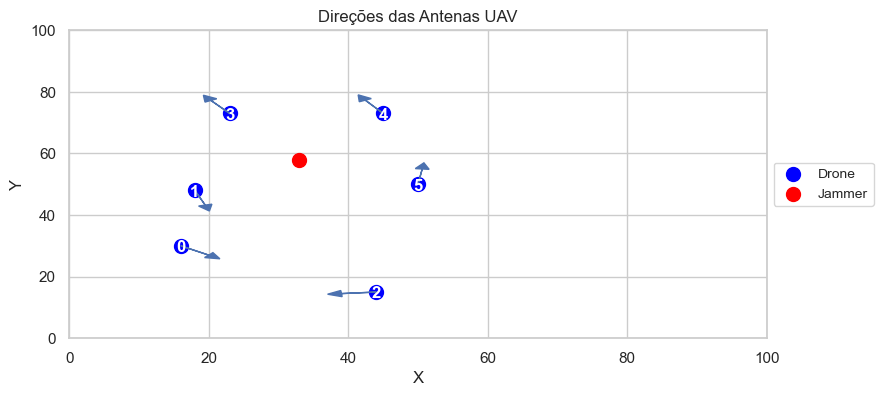

Melhor solução: [322.7810155  151.42709445 150.42534806 334.28435852 156.31785979
 180.41436734]

Capacidade Média [Kbps]:
109.476

Capacidade por Link [Kbps]:
[0.021, 22.907, 0.0, 0.001, 0.018, 0.184, 0.069, 0.001, 0.005, 0.007, 3132.549, 1.068, 0.067, 0.006, 0.0, 0.112, 0.102, 0.756, 91.529, 0.496, 0.018, 0.018, 0.001, 1.934, 0.0, 30.477, 1.378, 0.003, 0.552, 0.012]

Matriz de Capacidades [Kbps]:
	0.000 0.021 22.907 0.000 0.001 0.018
	0.184 0.000 0.069 0.001 0.005 0.007
	3132.549 1.068 0.000 0.067 0.006 0.000
	0.112 0.102 0.756 0.000 91.529 0.496
	0.018 0.018 0.001 1.934 0.000 0.000
	30.477 1.378 0.003 0.552 0.012 0.000


In [22]:
# Criação do ambiente
env = UAVCommunicationEnv()

# Criação do algoritmo genético
ga = GeneticAlgorithm(env)

# Executar o algoritmo genético
best_solution, best_info = ga.run()

# Renderizar a melhor solução
env.ultima_acao = best_solution
env.render()

print("Melhor solução:", best_solution)


if 'Capacidade média [Kbps]' in best_info:
        print("\nCapacidade Média [Kbps]:")
        capacidade_media=best_info['Capacidade média [Kbps]']
        print(capacidade_media)
    
if 'Capacidades_por_link [Kbps]' in best_info:
    print("\nCapacidade por Link [Kbps]:")
    capacidade_por_link=best_info['Capacidades_por_link [Kbps]']
    print(capacidade_por_link)


if 'Matriz de Capacidades [Kbps]' in best_info:
    print("\nMatriz de Capacidades [Kbps]:")
    capacidade_matriz = best_info['Matriz de Capacidades [Kbps]']
    print('\n'.join(['\t' + ' '.join(f"{item:.3f}" for item in row) for row in capacidade_matriz]))
else:
    print("Chave 'Matriz de Capacidades[Kbps]' não encontrada em info.")


MINIMUM SPANNING TREE

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.tree.mst.minimum_spanning_tree.html

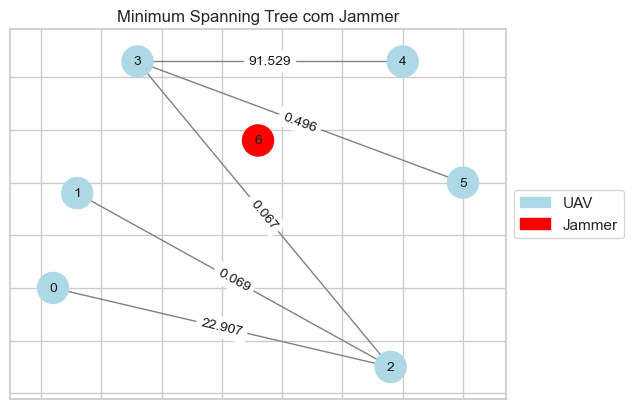

In [23]:
# Criar um grafo
G = nx.Graph()

# Adicionar arestas ao grafo com capacidades entre os drones, usando os dados de 'capacidade_matriz'
num_drones = posicoes.shape[0]
for i in range(num_drones):
    for j in range(i + 1, num_drones):
        capacidade = capacidade_matriz[i, j]
        G.add_edge(i, j, weight=-capacidade)  #pesos negativos, como se usasse o inverso das capacidades

# Calcular a Minimum Spanning Tree com a adaptação do algoritmo de Kruskal
mst = nx.minimum_spanning_tree(G, weight='weight')

# Criar o Gráfico
mst.add_node(num_drones)
pos = {i: (posicoes[i, 0], posicoes[i, 1]) for i in range(num_drones)}
pos[num_drones] = (posicao_jammer[0], posicao_jammer[1])  # Define a posição do jammer

node_colors = ['lightblue' for _ in range(num_drones)] + ['red']

fig, ax = plt.subplots()

# Desenhar o grafo
nx.draw_networkx_nodes(mst, pos, node_color=node_colors, node_size=500, ax=ax)
nx.draw_networkx_labels(mst, pos, font_size=10, ax=ax)
nx.draw_networkx_edges(mst, pos, ax=ax, edge_color='gray')

# Etiquetas para as arestas com capacidades (negativas, por isso o sinal é invertido para apresentação)
edge_labels = nx.get_edge_attributes(mst, 'weight')
nx.draw_networkx_edge_labels(mst, pos, edge_labels={(u, v): f"{-w:.3f}" for (u, v, w) in mst.edges(data='weight')}, ax=ax)

# Adicionar legenda com cores customizadas
uav_patch = mpatches.Patch(color='lightblue', label='UAV')
jammer_patch = mpatches.Patch(color='red', label='Jammer')
plt.legend(handles=[uav_patch, jammer_patch], loc='center left', bbox_to_anchor=(1, 0.5))

# Título e exibição do gráfico
plt.title("Minimum Spanning Tree com Jammer")
plt.axis('on')  # Garante que os eixos estão visíveis
plt.grid(True)  # Adiciona uma grade ao fundo
plt.show()